# NLP-Driven Advanced Twitter Sentiment Analysis: Hybrid Machine Learning vs Transformer Models

#### Loading packages

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import pandas as pd
import string
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import torch, codecs, random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from evaluate import load as load_metric
from google.colab import output
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from transformers import PreTrainedTokenizer
from torch.optim import Optimizer
import nltk
nltk.download("wordnet")
nltk.download("stopwords")
from nltk.stem import PorterStemmer

output.enable_custom_widget_manager()

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


## Data Preprocessing

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Tweets.csv")

df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11118
positive,8582
negative,7781


In [ ]:
df['text'] = df.text.astype(str)
df['sentiment'] = df['sentiment'].replace({'neutral': 0,
                                           'positive': 1,
                                           'negative': -1})

raw_tweets = df['text'].to_list()
labels = df['sentiment'].to_list()

In [ ]:
# Removing whitespaces from the tweets

basic_preproc_tweets = [a.split() for a in raw_tweets]
print(basic_preproc_tweets[:3])

#Featurize - bag of words

tweet_dicts = [dict(Counter(tweet)) for tweet in basic_preproc_tweets]
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(tweet_dicts)
vocabulary = vectorizer.get_feature_names_out()

print("Vocabulary:\n", vocabulary)
df_bow = pd.DataFrame(X, columns=vocabulary)
df_bow.head(5)

[['I`d', 'have', 'responded,', 'if', 'I', 'were', 'going'], ['Sooo', 'SAD', 'I', 'will', 'miss', 'you', 'here', 'in', 'San', 'Diego!!!'], ['my', 'boss', 'is', 'bullying', 'me...']]
Vocabulary:
 ['!' '!!' '!!!' ... 'ï¿½you' 'ï¿½ï¿½' 'ï¿½ï¿½h.']


,!,!!,!!!,!!!!,!!!!!,!!!!!!,!!!!!!!,!!!!!!!!,!!!!!!!!!,!!!!!!!!!!!!,...,ï¿½You,ï¿½anisalovesu,ï¿½n?eleg,ï¿½tearï¿½,ï¿½timo,ï¿½ureo,ï¿½why?,ï¿½you,ï¿½ï¿½,ï¿½ï¿½h.
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# regex patterns
HTML_URL_PATTERN = re.compile(r'<.*?>|http\S+')
NON_WORD_PATTERN = re.compile(r'\W+')  # Removes non-word characters

lemmatizer = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))

def pre_process_without_oov(text):
    # Remove HTML/URLs
    text = HTML_URL_PATTERN.sub('', text)
    words = text.split()

    processed_words = []
    for word in words:
        word = word.lower()                       # Lowercase
        word = NON_WORD_PATTERN.sub('', word)     # Remove punctuation
        if not word:
            continue
        word = lemmatizer.lemmatize(word)         # Lemmatize
        if word in STOP_WORDS:                    # Remove stopwords
            continue
        word = 'NUM' if word.isdigit() else word  # Replace numbers
        processed_words.append(word)

    return processed_words

# Apply initial preprocessing
df['temp_processed'] = df['text'].apply(pre_process_without_oov)

# Determine top 1000 words
all_words = [word for sublist in df['temp_processed'] for word in sublist]
word_counts = Counter(all_words)
TOP_FREQ_WORDS = set(word for word, _ in word_counts.most_common(1000))

# Second pass to apply OOV replacement
def replace_oov(words):
    return ['OOV' if word not in TOP_FREQ_WORDS else word for word in words]

df['cleaned_text'] = df['temp_processed'].apply(replace_oov)
df.drop(columns=['temp_processed'], inplace=True)

In [ ]:
df.head()

,textID,text,selected_text,sentiment,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",0,"[id, OOV, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,-1,"[sooo, sad, miss, OOV, OOV]"
2,088c60f138,my boss is bullying me...,bullying me,-1,"[OOV, OOV]"
3,9642c003ef,what interview! leave me alone,leave me alone,-1,"[interview, leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",-1,"[son, couldnt, put, OOV, already, bought]"


In [ ]:
raw_tweets = df['cleaned_text'].to_list()

In [ ]:
raw_tweets[:3]

[['id', 'OOV', 'going'], ['sooo', 'sad', 'miss', 'OOV', 'OOV'], ['OOV', 'OOV']]

In [ ]:
tweet_dicts = [dict(Counter(tweet)) for tweet in raw_tweets]
vectorizer_1 = DictVectorizer(sparse=False)
X_final = vectorizer_1.fit_transform(tweet_dicts)
vocabulary_final = vectorizer_1.get_feature_names_out()

print("Vocabulary:\n", vocabulary_final)

df_vocab = pd.DataFrame(X_final, columns=vocabulary_final)
df_vocab.head()

Vocabulary:
 ['1st' '2day' '2nd' ... 'yr' 'yum' 'yummy']


,1st,2day,2nd,3d,4th,NUM,OOV,_,able,absolutely,...,yet,yo,youll,young,youre,youtube,youve,yr,yum,yummy
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final,labels,test_size = 0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)

(20610, 1001)
(6871, 1001)


# Machine Learning Model

## Baseline Model


Base Line Classifier Model - that contains frequent category. For that we create a list that contains most frequent class and compare it with *y_pred_baseline*

In [ ]:
frequency_count = Counter(y_train)
print(frequency_count)


most_frequent_class = frequency_count.most_common(1)[0][0]
print(most_frequent_class)

y_pred_baseline = [most_frequent_class] * len(y_test)

baseline_model_accuracy_score = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Classifier Accuracy: {baseline_model_accuracy_score:.4f}")

Counter({0: 8331, 1: 6455, -1: 5824})
0
Baseline Classifier Accuracy: 0.4056


## Naive Bayes

In [ ]:
naive_bayes_model = MultinomialNB(alpha=1.0)

# We use alpha parameter to add add-1 smoothing

naive_bayes_model.fit(X_train,y_train)

y_pred = naive_bayes_model.predict(X_test)

nb_accuracy = accuracy_score(y_test,y_pred)
print(f"Model Accuracy - Naive Bayes: {nb_accuracy:.4f}")

Model Accuracy - Naive Bayes: 0.6555


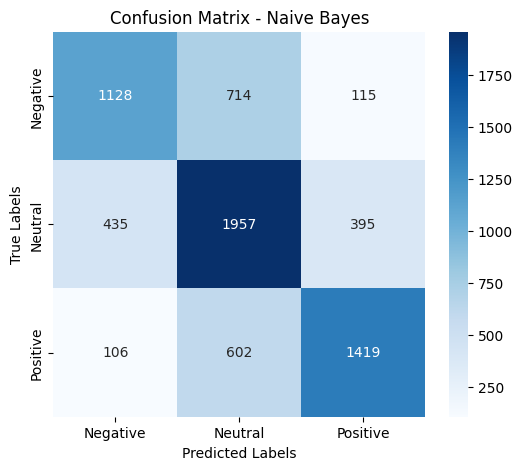

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

class_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


## Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter = 200,
                             multi_class = 'ovr')

lr_model.fit(X_train,y_train)
y_pred_lr = lr_model.predict(X_test)

lr_model_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Model Accuracy - Logistic Regression: {lr_model_accuracy:.4f}")

Model Accuracy - Logistic Regression: 0.6861


In [ ]:
frequency_count = Counter(y_train)
most_frequent_class = frequency_count.most_common(1)[0][0]
y_pred_baseline = [most_frequent_class] * len(y_test)

baseline_model_accuracy_score = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Classifier Accuracy: {baseline_model_accuracy_score:.4f}")

print(f"The Logistic Regression model is better from baseline with an improvement of {lr_model_accuracy - baseline_model_accuracy_score:.4f}")

Baseline Classifier Accuracy: 0.4056
The Logistic Regression model is better from baseline with an improvement of 0.2805


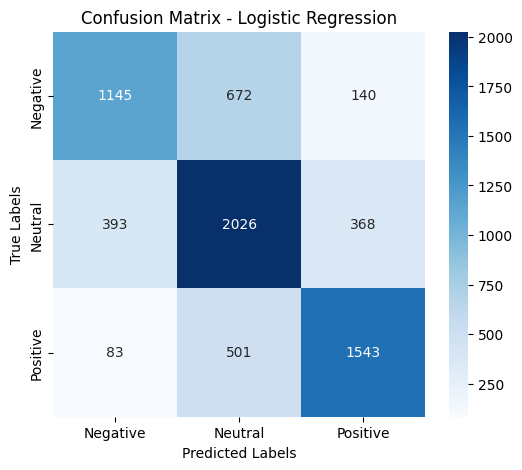

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

class_labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [ ]:
if lr_model_accuracy > nb_accuracy:
    print(f"The LR model is better from NB with a difference of: {(lr_model_accuracy - nb_accuracy) * 100} %")
else:
    print(f"The NB model is better from LR with a difference of {(nb_accuracy - lr_model_accuracy)*100} %")

The LR model is better from NB with a difference of: 3.056323679231554 %


# DistilBERT and BERT Fine-tuning for Sentiment Classification

In [5]:
assert torch.cuda.is_available()

In [6]:
dataset = df.copy()

#### Data Preparation

In [7]:
X = dataset['text'].to_list()
y = dataset['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).to_list()

In [8]:
# Splitting the data

trainset, trainlabs = X[:20610], y[:20610]
valset, vallabs = X[20610:22610], y[20610:22610]
testset, testlabs = X[22610:], y[22610:]

print(f"Training examples: {len(trainset)}")
print(f"Validation examples: {len(valset)}")
print(f"Test examples: {len(testset)}")

Training examples: 20610
Validation examples: 2000
Test examples: 4871


Preparing the dataset as BERT requires [CLS] and [SEP] tokens.

In [9]:
class TweetDataset(torch.utils.data.Dataset):
  """
  A PyTorch Dataset for our tweets that can be iterated through using __getitem__
  """
  def __init__(self, tweets : List[str], sentiments : List[int], tokenizer : PreTrainedTokenizer) -> None:
    """
    Initializes the TweetDataset from a list of tweets, their corresponding sentiments, and a tokenizer.

    Attributes
    ----------
    tweets : List[str]
      A list of tweets, where each tweet is a string
    sentiments: List[int]
      A list of sentiments represented as integers ('negative': 0, 'neutral': 1, 'positive': 2)
    tokenizer : PreTrainedTokenizer
      Any PreTrainedTokenizer from HuggingFace can be used to encode the string inputs for a model
    """
    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = tokenizer.model_max_length

  def __len__(self) -> int:
    """
    Returns the number of tweets in the dataset.
    """
    return len(self.tweets)

  def __getitem__(self, index : int) -> Dict[str, Any]:
    """
    Retrieve a preprocessed data item from the dataset at the specified index.
    This is called when iterating through a TweetDataset

    Parameters:
    ----------
    index : int
        The index of the data item to retrieve.

    Returns:
    -------
    Dict[str, Any]
        A dictionary containing the preprocessed data for the given index.
        The dictionary includes the following keys:
        - 'input_ids': Encoded input IDs for the tweet.
        - 'attention_mask': Attention mask for the tweet.
        - 'labels': Sentiment label as a PyTorch tensor.
    """
    tweet = str(self.tweets[index])
    sentiments = self.sentiments[index]

    encoded_tweet = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens      = True,
      max_length              = self.max_len,
      return_token_type_ids   = False,
      return_attention_mask   = True,
      return_tensors          = "pt",
      padding                 = "max_length",
      truncation              = True
    )

    return {
      'input_ids': encoded_tweet['input_ids'][0],
      'attention_mask': encoded_tweet['attention_mask'][0],
      'labels': torch.tensor(sentiments, dtype=torch.long)
    }

### Tokenizer and dataloader

In [10]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# tokenizer argument of the TweetDataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# TweetDataset objects
train_dataset = TweetDataset(trainset,trainlabs,tokenizer)
validation_dataset = TweetDataset(valset,vallabs,tokenizer)
test_dataset = TweetDataset(testset,testlabs,tokenizer)

# constructing DataLoader objects from the TweetDataset objects
train_dataloader = DataLoader(train_dataset,batch_size=32, shuffle = True)
validation_dataloader = DataLoader(validation_dataset,batch_size=32, shuffle = False)
test_dataloader = DataLoader(test_dataset,batch_size=32, shuffle = False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Baseline Untrained Model

In [11]:
from transformers import AutoConfig, AutoModelForSequenceClassification

# getting the distilbert-base-uncased config...
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3)

untrained_model = AutoModelForSequenceClassification.from_config(config)

In [12]:
# Evaluating model predictions on untrained model

# For any parameter named 'device', pass the following variable:
device = torch.device("cuda")

# Loading the model onto the device
untrained_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [13]:
def update_metrics(metrics, predictions: torch.Tensor, labels: torch.Tensor) -> None:
  """
  Update a list of metrics with new predictions and labels

  Parameters:
  -----------
  metrics : List[Metric]
      List of metrics.
  predictions : torch.Tensor
      Tensor of predictions of shape (batch_size, ...)
  labels : torch.Tensor
      Tensor of labels of shape (batch_size, ...)

  Returns:
  --------
  None
  """
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model: torch.nn.Module, test_dataloader: torch.utils.data.DataLoader,
             device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
  """
  Evaluate a PyTorch Model

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be evaluated.
  test_dataloader : torch.utils.data.DataLoader
      DataLoader containing testing examples.
  device : torch.device
      The device that the evaluation will be performed on.
  metric_strs : List[str]
      The names of Hugging Face metrics to use.

  Returns:
  --------
  Dict[str, float]
      Dictionary of metric names mapped to their values.
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # progress bars :)
  progress_bar = tqdm(range(len(test_dataloader)))

  with torch.no_grad():
    for batch in test_dataloader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim = -1).detach()

        update_metrics(metrics, predictions, labels)

        progress_bar.update(1)

  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed

#### Baseline performance

In [14]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs: List[float], names: List[str]) -> None:
  """
  Create bar plots for performance metrics.

  Parameters:
  -----------
  perfs : List[float]
      List of performance values (e.g., accuracies).
  names : List[str]
      List of names for the corresponding performance metrics.
  """
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

  0%|          | 0/153 [00:00<?, ?it/s]

Baseline accuracy: 0.4136727571340587


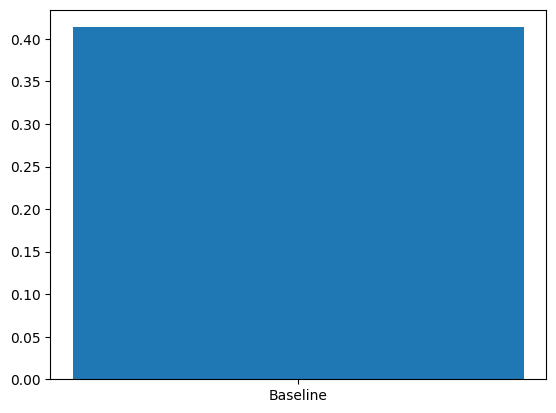

None


In [15]:
metrics = ['accuracy']

baseline_result = evaluate(model = untrained_model,
                           test_dataloader = test_dataloader,
                           device = device,
                           metric_strs = metrics)['accuracy']


#PLOT
results = [baseline_result]
names = ['Baseline']
print(make_plots(results, names))

### Baseline - Training the untrained model

In [ ]:
def train(model: torch.nn.Module, optimizer: Optimizer, num_epochs: int,
          train_dataloader: DataLoader, validation_dataloader: DataLoader,
          lr_scheduler: Any, device: torch.device) -> None:
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  optimizer : torch.optim.Optimizer
      The training optimizer.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  None
  """

  # CrossEntropyLoss - loss function
  loss_function = torch.nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    for batch in train_dataloader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_function(logits, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()

        predictions = torch.argmax(logits, dim=-1).detach()
        for metric in metrics:
            metric.add_batch(predictions=predictions, references=labels)

        progress_bar.update(1)

    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")

    val_metrics = evaluate(model, validation_dataloader, device, ["accuracy"])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")

In [ ]:
# Training the model

from transformers import get_scheduler
from torch.optim import AdamW

num_epochs = 2

optimizer = AdamW(untrained_model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

torch.cuda.empty_cache()
untrained_model.to(device)

train(untrained_model,
      optimizer, num_epochs,
      train_dataloader,
      validation_dataloader,
      lr_scheduler,
      device)

Epoch 1 training:


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.5763706938379427
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.715
Epoch 2 training:


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.7473556525958273
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.7195


  0%|          | 0/153 [00:00<?, ?it/s]

Baseline accuracy: 0.3044549373845206
Manually Trained accuracy: 0.7290084171628003


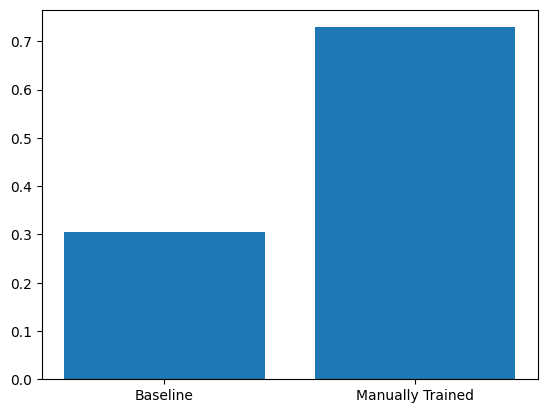

In [ ]:
# Evaluate

metrics = ['accuracy']

# Evaluate on test dataset!
trained_result = evaluate(model=untrained_model,
    test_dataloader=test_dataloader,
    device=device,
    metric_strs=["accuracy"])['accuracy']

# Plot
results = baseline_result, trained_result
names = ['Baseline', 'Manually Trained']
make_plots(results, names)

### Fine-tuning pre-trained DistilBERT model

In [ ]:
# Load pre-trained model

from transformers import DistilBertForSequenceClassification

pretrained_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased" , num_labels = 3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/153 [00:00<?, ?it/s]

Baseline accuracy: 0.3044549373845206
Manually trained accuracy: 0.7290084171628003
Pre-trained accuracy: 0.2882365017450216


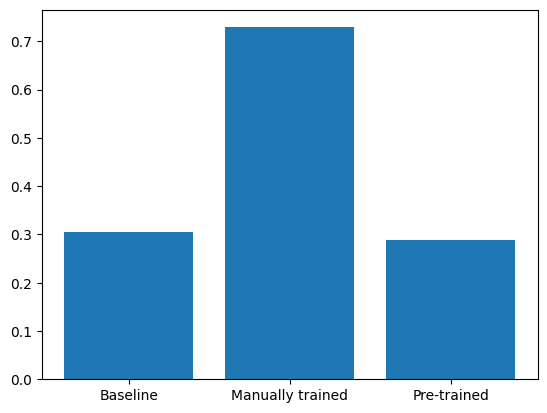

In [ ]:
device = torch.device("cuda")

pretrained_model.to(device)

pretrained_result = evaluate(
    model=pretrained_model,
    test_dataloader=test_dataloader,
    device=device,
    metric_strs=["accuracy"]
)['accuracy']

#Plot
results = [baseline_result, trained_result, pretrained_result]
names = ['Baseline', 'Manually trained', 'Pre-trained']
make_plots(results, names)

Rather than train the model from scratch, we'll now fine-tune the pre-trained model! That is, we will take the model that was trained to predict masked words,
and now train it on our sentiment analysis task.
We'll fine-tune by simply running the `train` function on our pre-trained model with the training data! Fine-tuning it for **2 epochs**.

In [ ]:
num_epochs = 2

optimizer = AdamW(pretrained_model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

torch.cuda.empty_cache()
pretrained_model.to(device)

#Training
train(pretrained_model,
      optimizer,
      num_epochs,
      train_dataloader,
      validation_dataloader,
      lr_scheduler,
      device)

Epoch 1 training:


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.7467734109655507
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.7925
Epoch 2 training:


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.8497816593886462
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.796


  0%|          | 0/153 [00:00<?, ?it/s]

Baseline accuracy: 0.3044549373845206
Manually trained accuracy: 0.7290084171628003
Pre-trained accuracy: 0.2882365017450216
Fine-tuned accuracy: 0.7860808868815439


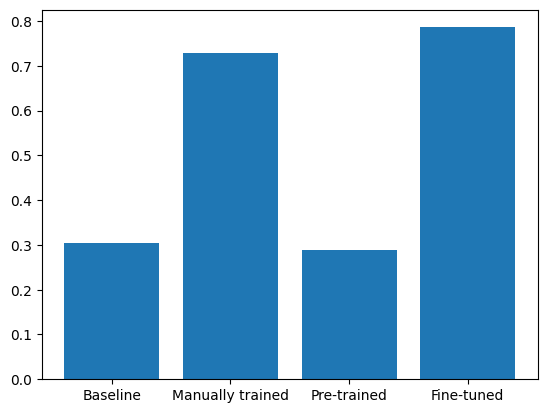

In [ ]:
# Evaluating the fine-tuned model

finetuned_result = evaluate(
    model = pretrained_model,
    test_dataloader = test_dataloader,
    device = device,
    metric_strs = ['accuracy']
)['accuracy']

#Plot
results = [baseline_result, trained_result, pretrained_result, finetuned_result]
names = ['Baseline', 'Manually trained', 'Pre-trained', 'Fine-tuned']
make_plots(results, names)

## Fine-tuning pre-trained BERT Model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_scheduler

bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=3
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Evaluate pre-trained model on test set
bert_pretrained_result = evaluate(
    model=bert_model,
    test_dataloader=test_dataloader,
    device=device,
    metric_strs=["accuracy"]
)['accuracy']

print(bert_pretrained_result)

  0%|          | 0/153 [00:00<?, ?it/s]

0.41757339355368506


In [ ]:
# Fine-tune BERT
num_epochs = 2
optimizer = AdamW(bert_model.parameters(), lr=5e-5)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=len(train_dataloader) * num_epochs
)

torch.cuda.empty_cache()
bert_model.to(device)

train(
    bert_model,
    optimizer,
    num_epochs,
    train_dataloader,
    validation_dataloader,
    lr_scheduler,
    device
)

Epoch 1 training:


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.7450752062105774
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.7845
Epoch 2 training:


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.861475012130034
Running validation:


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.798


  0%|          | 0/153 [00:00<?, ?it/s]

Baseline accuracy: 0.3044549373845206
Manually trained accuracy: 0.7290084171628003
DistilBERT Pre-trained accuracy: 0.2882365017450216
DistilBERT Fine-tuned accuracy: 0.7860808868815439
BERT Pre-trained accuracy: 0.41757339355368506
BERT Fine-tuned accuracy: 0.7930609731061383


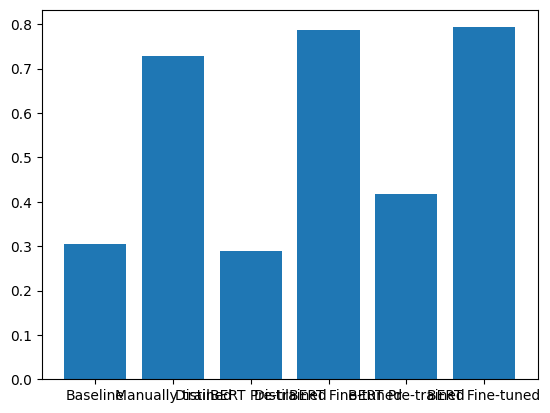

In [ ]:
# Evaluate fine-tuned BERT model
bert_finetuned_result = evaluate(
    model=bert_model,
    test_dataloader=test_dataloader,
    device=device,
    metric_strs=['accuracy']
)['accuracy']

# Results to compare BERT and DistilBERT
results = [
    baseline_result, trained_result,
    pretrained_result, finetuned_result,  # DistilBERT
    bert_pretrained_result, bert_finetuned_result  # BERT
]

names = [
    'Baseline', 'Manually trained',
    'DistilBERT Pre-trained', 'DistilBERT Fine-tuned',
    'BERT Pre-trained', 'BERT Fine-tuned'
]

#Plot
make_plots(results, names)

# Analysis


Sentiment analysis is a key task in Natural Language Processing (NLP), helping to determine whether a given text expresses a positive, negative, or neutral sentiment. Traditional machine learning models, such as Naïve Bayes and Logistic Regression, have been widely used for this task. However, recent advancements in transformer-based models, such as DistilBERT and BERT, have significantly improved sentiment classification performance.

--------------------------------------------
| Model                        | Accuracy  |
--------------------------------------------
| Naïve Bayes                  | 0.6555    |
| Logistic Regression           | 0.6861   |
--------------------------------------------
| Baseline (Random DistilBERT)  | 0.3045   |
| Manually Trained Model        | 0.7290   |
--------------------------------------------
| DistilBERT Pre-trained        | 0.2882   |
| DistilBERT Fine-tuned         | 0.7861   |
--------------------------------------------
| BERT Pre-trained              | 0.4175   |
| BERT Fine-tuned               | 0.7931   |
--------------------------------------------

Key Observations:

Traditional ML Models:
Logistic Regression (0.6861) outperforms Naïve Bayes (0.6555), likely due to its ability to capture more complex decision boundaries.
Despite being simple, these models provide strong baseline performance.

Transformer-Based Models (Pre-trained vs. Fine-tuned):

1. Pre-trained DistilBERT (0.2882) and Pre-trained BERT (0.4175) perform poorly when used without fine-tuning, indicating that direct zero-shot application is ineffective.
2. Fine-tuned DistilBERT (0.7861) and Fine-tuned BERT (0.7931) significantly outperform traditional models, demonstrating the effectiveness of domain adaptation.

BERT vs. DistilBERT:

Fine-tuned BERT (0.7931) slightly outperforms Fine-tuned DistilBERT (0.7861), showing that the full BERT model retains richer contextual information.
However, DistilBERT is a lighter and faster model, making it a better choice when computational efficiency is required.

## Insights

For production systems, DistilBERT Fine-tuned is an excellent balance between accuracy and efficiency. However, if computational cost is not a concern, fine-tuned BERT remains the best-performing model. Traditional models like Logistic Regression still serve as effective baselines for quick and lightweight sentiment analysis tasks.